# Face Keypoint Detector

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
import math
import pandas as pd
from scipy import misc
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
%matplotlib inline

C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Configure Network

In [52]:
data_directory = "/data/"
training_filename = "training.csv"
batch_size = 128
num_epochs=500
dropout =False
use_ConvNet = True
xavier_weights = True
learning_amount= .01
momentum_amount = 0.9
learn_decay = False
momentum_inc = False
opt = "SGD"

model_name = "ConvNet" + str(learning_amount) + "_" + str(num_epochs) + opt
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/FinalModels/" + model_name
model_path = model_directory + "/" + model_filename

# Images are 96 x 96 grayscale with 15 features using (x, y) coordinates
image_size = 96
num_channels = 1 # grayscale
num_classes = 30

# Load the Data

In [28]:
import copy

class MiniBatcher(object):
    def __init__(self, batch_size, shuffle=False, seed=43):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, X, y=None):
        if self.shuffle:
            _shuffle_arrays([X, y] if y is not None else [X], self.random)
        self.X, self.y = X, y
        return self

        
    def __iter__(self):
        bs = self.batch_size
        for i in range((self.n_samples + bs - 1) // bs):
            sl = slice(i * bs, (i + 1) * bs)
            Xb = _sldict(self.X, sl)
            if self.y is not None:
                yb = _sldict(self.y, sl)
            else:
                yb = None
            yield self.transform(Xb, yb)
            

    @property
    def n_samples(self):
        X = self.X
        if isinstance(X, dict):
            return len(list(X.values())[0])
        else:
            return len(X)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state
    
def _shuffle_arrays(arrays, random):
    rstate = random.get_state()
    for array in arrays:
        if isinstance(array, dict):
            for v in list(array.values()):
                random.set_state(rstate)
                random.shuffle(v)
        else:
            random.set_state(rstate)
            random.shuffle(array)
            
def _sldict(arr, sl):
    if isinstance(arr, dict):
        return {k: v[sl] for k, v in arr.items()}
    else:
        return arr[sl]
    
class AugBatcher(MiniBatcher):

    def __init__(self, batch_size, shuffle=False, seed=1, add_flips=False, add_rotate=False):
        super(AugBatcher, self).__init__(batch_size, shuffle=False, seed=1)
        self.add_flips = add_flips
        self.add_rotate = add_rotate
        self.flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(AugBatcher, self).transform(Xb, yb)

        Xb = copy.deepcopy(Xb)
        yb = copy.deepcopy(yb)
        if self.add_flips:
        # Flip half of the images in this batch at random:
            bs = Xb.shape[0]
            indices = np.random.choice(bs, int(bs / 2), replace=False)
            Xb[indices] = Xb[indices, :, ::-1, :]

            if yb is not None:
                # Horizontal flip of all x coordinates:
                yb[indices, ::2] = yb[indices, ::2] * -1

                # Swap places, e.g. left_eye_center_x -> right_eye_center_x
                for a, b in self.flip_indices:
                    yb[indices, a], yb[indices, b] = (
                        yb[indices, b], yb[indices, a])
        
        #print("Before: " + str(Xb[0]))
        if self.add_rotate:
            for i in range(0, len(Xb)): 
                if random.uniform(0, 1) > .5:
                    angle = random.uniform(-5, 5)
                    Xb[i] = np.reshape(misc.imrotate(np.reshape(Xb[i], [image_size, image_size]), -angle), [1, image_size, image_size, 1]) / 255
                    for j in range(0, 30, 2):
                        yb[i, j], yb[i, j+1] = rotatePoint((0, 0), (yb[i, j], yb[i, j+1]), angle)
        
        #print("After: " + str(Xb[0]))
        return Xb, yb

def rotatePoint(centerPoint,point,angle):
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

In [4]:
def loadData(filename):
    
    df = pd.read_csv(filename)

    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    df = df.dropna()

    values = np.vstack(df['Image'].values) / 255.
    values = values.astype(np.float32)

    labels = df[df.columns[:-1]].values
    labels = (labels - 48) / 48  
    values, labels = shuffle(values, labels, random_state=3)  
    labels = labels.astype(np.float32)

    return values, labels

In [6]:
image_values, image_labels = loadData(os.getcwd() + data_directory + training_filename)
image_values = np.reshape(image_values, [-1, image_size, image_size, 1])

TypeError: Singleton array array(0.5) cannot be considered a valid collection.

In [33]:
train_data, validation_data, train_labels, validation_labels = train_test_split(image_values, image_labels, test_size = 0.3)
valid_data, test_data, valid_labels, test_labels = train_test_split(validation_data, validation_labels, test_size=0.5)

In [19]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    if(xavier_weights):
        print("Xavier Weights")
        weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    else:
        print("Zero Weights")
        weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer=tf.constant_initializer(0))
        
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    total_parameters = x_input.get_shape()[1] * width + width
    
    print("Created Fully Connected Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [20]:
def createConvolutionLayer(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    if xavier_weights:
        print("Xavier Weights")
        weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    else:
        print("Zero Weights")
        weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer=tf.constant_initializer(0))
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    added = tf.nn.bias_add(convolution, biases)
    
    total_parameters = kernel_size*kernel_size*features*depth + depth
    print("Created Convolution Layer: Input" + str(x_input.get_shape()) + " Parameters(" + str(total_parameters) + ")")
    
    return tf.nn.relu(added)

In [21]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLU in graph
    # 
    print("Created RELU Activation Function")
    return tf.nn.relu(x_input)

In [22]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    
    print("Created Pooling Layer: Downsample:" + str(kernel_size))
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

In [23]:
def createSimpleNetwork(model_input):
    with tf.variable_scope('input'):
        input_layer = tf.reshape(model_input, [-1, image_size * image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(input_layer, 100)
    relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        model_output = createFullyConnectedLayer(relu_layer, 30)
        
    print("Simple Network Created")
    return model_output

In [24]:
def createConvNetwork(x_input, is_train):
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 1, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer1, keep_prob = 0.9 if dropout else 1.0), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 32, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer2, keep_prob = 0.8 if dropout else 1.0), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 64, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer3, keep_prob = 0.7 if dropout else 1.0), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    print("fc: input size before flattening: " + str(pooling_layer3.get_shape()))
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 1000)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(is_train, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob = 0.5 if dropout else 1.0), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 1000)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, 30)
        print("out: " + str(output.get_shape()))
    return output

## Training

In [45]:
def trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, rotate):
    start = time.time()
    train_loss_list = []
    valid_loss_list = []
    time_list = []
    epoch_list = []
    print("TRAINING: " + model_name)

    with tf.Session(graph = graph) as session:

        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        #if os.path.exists(model_directory):
        #    print("Loading model...")
        #    load_path = saver.restore(session, model_path)

        for epoch in range(num_epochs):
            batch = AugBatcher(batch_size=batch_size, shuffle=True, add_flips=flip, add_rotate=rotate)
            for batch_data, batch_labels in batch(train_images, train_labels):
                feed_dict = {model_input: batch_data, model_output: batch_labels, model_training: True}
                # train model
                session.run([model_optimizer], feed_dict = feed_dict)

            #Store train and validation losses
            if epoch % 10 == 0:
                train_loss = getLoss(train_images, train_labels, session)
                train_loss_list.append(train_loss)
                valid_loss = getLoss(valid_images, valid_labels, session)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                if learn_decay:
                    print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f" % learning_rate.eval())
                else:
                    print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f" % learning_rate)
                
                time_list.append(current_time)
                epoch_list.append(epoch)

            if epoch % 300 == 0:
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving Model...")    
                save_path = saver.save(session, model_path)
            # Evaluate on test dataset.
            step = session.run(increment_global_step_op)
        test_loss = getLoss(test_images, test_labels, session)
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) #RMSE
        if not os.path.exists(model_directory):
            os.mkdir(model_directory)
        print("Saving Model...")
        save_path = saver.save(session, model_path)
        saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, [test_loss], 'Loss3')

In [46]:
def getLoss(values, labels, session):
    loss_ = []
    batch = MiniBatcher(batch_size = 128)
    for batch_values, batch_labels in batch(values, labels):
        loss_batch = session.run(model_loss, feed_dict = {model_input : batch_values, model_output : batch_labels, model_training : False})
        loss_.append(loss_batch)
    return np.mean(loss_)

def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

def saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, test_loss, name):
    df = pd.DataFrame({'Epochs' : epoch_list, 'Time' :  time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
    df2 = pd.DataFrame({'Test:' : test_loss})
    df = pd.concat([df,df2], axis=1)
    writer = pd.ExcelWriter(model_path + name + '.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.save()

In [ ]:
graph = tf.Graph()

with graph.as_default():
    
    model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 1))
    model_output = tf.placeholder(tf.float32, shape=(None, 30))
    model_training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0, trainable=False)
    increment_global_step_op = tf.assign(current_epoch, current_epoch+1)
    
    #Parameters

    if learn_decay:
        print("learn decay on")
        learning_rate = tf.train.exponential_decay(learning_amount, current_epoch, decay_steps=num_epochs, decay_rate=.9)
    else:
        learning_rate = learning_amount
    if momentum_inc:
        m_min = 0.9
        m_max = 0.99
        print("momentum increase on")
        momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
    else:
        momentum_rate = momentum_amount
    # get model
    if dropout:
        print("Dropout on")
    
    if(use_ConvNet):
        with tf.variable_scope(model_name):
            model_predictions = createConvNetwork(model_input, model_training)
    else:
        with tf.variable_scope(model_name):
            model_predictions = createSimpleNetwork(model_input)
    
    model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))
    
    if opt == "MOM":
        print("Using Momentum Optimizer")
        model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
    elif opt == "ADAM":
        print("Using ADAM Optimizer")
        model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    else:
        print("Using SGD Optimizer")
        model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss)

trainModel(train_data, train_labels, valid_data, valid_labels, test_data, test_labels, num_epochs, batch_size, model_name, True, True)

Xavier Weights
Created Convolution Layer: Input(?, 96, 96, 1) Parameters(320)
Created Pooling Layer: Downsample:2
Xavier Weights
Created Convolution Layer: Input(?, 48, 48, 32) Parameters(8256)
Created Pooling Layer: Downsample:2
Xavier Weights
Created Convolution Layer: Input(?, 24, 24, 64) Parameters(32896)
Created Pooling Layer: Downsample:2
fc: input size before flattening: (?, 12, 12, 128)
Xavier Weights
Created Fully Connected Layer: Input(?, 18432) Parameters(18433000)
Created RELU Activation Function
Xavier Weights
Created Fully Connected Layer: Input(?, 1000) Parameters(1001000)
Created RELU Activation Function
Xavier Weights
Created Fully Connected Layer: Input(?, 1000) Parameters(30030)
out: (?, 30)
Using SGD Optimizer
TRAINING: ConvNet0.01_500SGD
Epoch[   0]0: 0: 4 0.124364  0.125541 0.010000
Saving Model...
Epoch[  10]0: 0:35 0.008346  0.008109 0.010000
Epoch[  20]0: 1: 7 0.007631  0.007375 0.010000
Epoch[  30]0: 1:40 0.007287  0.007041 0.010000
Epoch[  40]0: 2:12 0.006988

### Sanity Check

In [ ]:
for i in range(len(x_valid)):
    for j in range(len(x_test)):
        if np.array_equal(x_valid[i], x_test[j]):
            print("CROSS CONTAMINATED")

# Get Predictions and output to screen

In [50]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    #p = session.run(model_predictions, feed_dict={model_input: np.reshape(new_image, [1, 96, 96, 1]), model_training:False})
    p = session.run(model_predictions, feed_dict={model_input: test_data, model_training:False})
    #loss = session.run(loss_function, feed_dict={tf_x_batch: x_valid, y_output: y_valid, is_training:False})

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on C:\Users\sethd\CNNTutorials\7. FacialFeatureDetection_Tutorial/FinalModels/ConvNet0.001_500SGD/ConvNet0.001_500SGD.ckpt: Not found: FindFirstFile failed for: C:/Users/sethd/CNNTutorials/7. FacialFeatureDetection_Tutorial/FinalModels/ConvNet0.001_500SGD : The system cannot find the path specified.

	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_4/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_106_save_1/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_1/RestoreV2', defined at:
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-2f5a379e5031>", line 3, in <module>
    saver = tf.train.Saver()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 1000, in __init__
    self.build()
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 624, in build
    restore_sequentially, reshape)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\sethd\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on C:\Users\sethd\CNNTutorials\7. FacialFeatureDetection_Tutorial/FinalModels/ConvNet0.001_500SGD/ConvNet0.001_500SGD.ckpt: Not found: FindFirstFile failed for: C:/Users/sethd/CNNTutorials/7. FacialFeatureDetection_Tutorial/FinalModels/ConvNet0.001_500SGD : The system cannot find the path specified.

	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_1/Const_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
	 [[Node: save_1/RestoreV2_4/_13 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_106_save_1/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


NameError: name 'x_test' is not defined

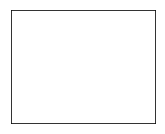

In [49]:
###### import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 150))

for i in range(300):
    axis = fig.add_subplot(60, 5, i + 1, xticks=[], yticks=[])
    img = x_test[i]
    img = img.reshape(96, 96)
    y = y_test[i]
    y2 = p[i]
    axis.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = new_image
    img = img.reshape(96, 96)
    #y = y_test[i]
    y2 = p[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = new_image
    img = img.reshape(96, 96)
    #y = y_test[i]
    y2 = p[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

### Insert New Image and Predict Keypoints

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

new_image = mpimg.imread('sethdecker6.jpg')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#new_image = rgb2gray(new_image)
plt.imshow(new_image)

new_image = new_image / 255

plt.imshow(new_image, cmap="gray")

# Cross Validation for Checking Model Robustness 

In [ ]:
kfolds = 5
flip = True
dropout = True
use_ConvNet = True
num_epochs = 1000

learning_amount= 0.12
momentum_amount = 0.9
learn_decay = True
momentum_inc = True
opt = "MOM"

skf = KFold(n=len(image_values), n_folds=kfolds)
i = 0
for train_index, test_index in skf:

    learning_rate = learning_amount
    momentum_rate = momentum_rate
    train_images1 = np.array([image_values[i] for i in train_index])
    train_labels1 = np.array([image_labels[i] for i in train_index])
    
    test_images = np.array([image_values[i] for i in test_index])
    test_labels = np.array([image_labels[i] for i in test_index])
    
    
    print(train_images1[0].shape)
    graph = tf.Graph()

    with graph.as_default():

        noise = False
        bright= False
        rotate = False

        model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 1))
        model_output = tf.placeholder(tf.float32, shape=(None, 30))
        model_training = tf.placeholder(tf.bool)

        current_epoch = tf.Variable(0, trainable=False)
        increment_global_step_op = tf.assign(current_epoch, current_epoch+1)
        #Define Parameters


        if learn_decay:
            print("learn decay on")
            learning_rate = tf.train.exponential_decay(learning_amount, current_epoch, decay_steps=num_epochs, decay_rate=0.9)
        else:
            learning_rate = learning_amount
        if momentum_inc:
            m_min = 0.9
            m_max = 0.99
            print("momentum increase on")
            momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
        else:
            momentum_rate = momentum_amount
            
        #Model Name
        model_name = "ConvNet-CV" + "_Best" + str(i) + str("_LRN") + str(learning_amount) + "_Epochs" + str(num_epochs)
        model_filename = model_name + ".ckpt"
        model_directory = os.getcwd() + "/Models5/" + model_name
        model_path = model_directory + "/" + model_filename
            
        # get model
        if(use_ConvNet):
            with tf.variable_scope(model_name):
                model_predictions = createConvNetwork(model_input, model_training)
        else:
            with tf.variable_scope(model_name):
                model_predictions = createSimpleNetwork(model_input)

        model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))

        if opt == "MOM":
            print("Using Momentum Optimizer")
            model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
        elif opt == "ADAM":
            print("Using ADAM Optimizer")
            model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
        else:
            print("Using SGD Optimizer")
            model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss)

        flip = True

        trainModel(train_images1, train_labels1, test_images, test_labels, test_images, test_labels, num_epochs, batch_size, model_name, True, False, False, False)
    i = i + 1

In [ ]:
kfolds = 3
#kfolds loop
#new name
#train
print("hello")
momentum_steps = [0, 1, 2] 

learning_steps = [0.0001, 0.001, 0.01, 0.1, 1]
learn_decay = False
dropout = False
use_ConvNet = False
num_epochs = 1000

skf = KFold(n_splits=kfolds, random_state=None, shuffle=False)
i = 0
for train_index, test_index in skf.split(image_values):
    print(i)
    kfolds2 = 4
    momentum_rate = momentum_steps[i]
    train_images1 = [image_values[i] for i in train_index]
    train_labels1 = [image_labels[i] for i in train_index]
    
    test_images = [image_values[i] for i in test_index]
    test_labels = [image_labels[i] for i in test_index]
    j = 0
    skf2 = KFold(n_splits=kfolds2, random_state=None, shuffle=False)
    for train_index2, valid_index in skf2.split(train_images1):
        print(j)
        learning_rate = learning_steps[j]
        
        train_images = np.asarray([train_images1[i] for i in train_index2])
        train_labels = np.asarray([train_labels1[i] for i in train_index2])
        valid_images = np.asarray([train_images1[i] for i in valid_index])
        valid_labels = np.asarray([train_labels1[i] for i in valid_index])
                
        graph = tf.Graph()
        
        with graph.as_default():

            model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
            model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
            model_training = tf.placeholder(tf.bool)

            current_epoch = tf.Variable(0, trainable=False)
            #Define Parameters

            if learn_decay:
                #learning_rate = tf.train.exponential_decay(learning_steps[j], current_epoch, decay_steps=num_epochs, decay_rate=0.03)
                learning_rate = tf.train.exponential_decay(
                                  learning_steps[j],                # Base learning rate.
                                  current_epoch,  # Current index into the dataset.
                                  num_epochs,          # Decay step.
                                  0.9,                # Decay rate.
                                  staircase=True)
            else:
                learning_rate = learning_steps[j]
                print("LEARNING RATE:" + str(learning_rate))

            if momentum_inc:
                m_min = 0.9
                m_max = 0.99
                momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
            else:
                momentum = momentum_amount

            #Model Name
            model_name = "ConvNet-CV" + "_Opt" + str(i) + str("_LRN") + str(learning_steps[j]) + "_Epochs" + str(num_epochs)
            model_filename = model_name + ".ckpt"
            model_directory = os.getcwd() + "/Models5/" + model_name
            model_path = model_directory + "/" + model_filename

            # get model
            if(use_ConvNet):
                with tf.variable_scope(model_name):
                    model_predictions = createConvNetwork(model_input, model_training)
            else:
                with tf.variable_scope(model_name):
                    model_predictions = createSimpleNetwork(model_input)

            model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))

            if momentum_steps[i] == 0:
                model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss, global_step = current_epoch)
            elif momentum_steps[i] == 1:
                model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss, global_step = current_epoch)
            else:
                model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss, global_step = current_epoch)



        trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate)

        j = j + 1
    i = i + 1